In [ ]:
#This script was run from Google colab, so it was necessary to mount my Google drive to access the image files and save the 
#resulting path

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Install package to unzip .rar file
!pip install unrar

In [ ]:
#Unzip the files
!unrar x '/content/drive/My Drive/Gina.rar'

Streaming output truncated to the last 5000 lines.
Extracting  Gina/train/1011.jpg                                           84%  OK 
Extracting  Gina/train/1015.jpg                                           84%  OK 
Extracting  Gina/train/1016.jpg                                           84%  OK 
Extracting  Gina/train/1018.jpg                                           84%  OK 
Extracting  Gina/train/1019.jpg                                           84%  OK 
Extracting  Gina/train/102.jpg                                            84%  OK 
Extracting  Gina/train/1020.jpg                                           84%  OK 
Extracting  Gina/train/1021.jpg                                           84%  OK 
Extracting  Gina/train/1022.jpg                                           84%  OK 
Extracting  Gina/train/1025.jpg                                           84%  OK 
Extracting  Gina/train/1027.j

In [ ]:
# Specify path
PATH = '/content/Gina/'

In [ ]:
#Imports
import pandas as pd
import os
import glob
import numpy as np
from tqdm import tqdm
import shutil
import pickle




#Read in the csv data
data = pd.read_csv(PATH + 'labels.csv', delim_whitespace=True)
#Create an index
data.set_index('img_name', inplace=True)
#Instead of values 1,-1 I set 0,1 (replace all -1 with 0)
data.replace(-1,0, inplace= True)
#Read in to pickle file
data.to_pickle(PATH + 'data_pkl.pkl')


# for i in ['train', 'valid']:
#     os.mkdir(os.path.join(PATH , i))

#Find the image files/names
filenames = glob.glob(PATH + 'img/*jpg')
#Random shuffle so avoid biased training
shuffle = np.random.permutation(len(filenames))

#Create dataframes
training_df = pd.DataFrame()
valid_df = pd.DataFrame()

#Create seperate folders for training and validation & show progress bar

#Split 4,500 image files into training folder
for j in tqdm(shuffle[:4500]):
    file = filenames[j].split('/')[-1]
    training_df = training_df.append( data[data.index == file])
    shutil.copy(PATH + 'img/' + file, PATH + 'train/' + file)

#Split the remaining 500 image files into validation folder
for j in tqdm(shuffle[4500:]):
    file = filenames[j].split('/')[-1]
    valid_df = valid_df.append(data[data.index == file])
    shutil.copy(PATH +'img/'+ file, PATH + 'valid/' + file)

100%|██████████| 500/500 [00:00<00:00, 920.59it/s]


In [ ]:
#Create csv and pickle files 
training_df.to_csv(PATH + 'train.csv')
training_df.to_pickle((PATH + 'train.pkl'))

valid_df.to_csv(PATH + 'valid.csv')
valid_df.to_pickle(PATH + 'valid.pkl')

In [ ]:
#Imports
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import PIL
import sklearn
import torch
import torchvision
import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import os

#Outsource computing power to Google servers to avoid computer damage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Define a class that will load the data when called
class Gender_loader(Dataset):
    def __init__(self, df, img_dir, transform = None):
        self.dataframe = df
        self.img_dir = img_dir
        self.transform = transform
        self.filename = df.index
        self.label = df.gender.values

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.filename[idx]))
        label = self.label[idx]
        sample = {'image': image, 'label': label}
        if self.transform:
            image = self.transform(sample['image'])
            sample = {'image': image, 'label': label}

        return sample


In [ ]:
#Use pre-constructed model architectures accessed via urls
import torch
import torch.nn as nn
from torchvision import models

#Specify model - use vgg19 as it is most accurate
model = models.vgg19_bn(pretrained = True)

for param in model.parameters():
    param.requires_grad = True

#Change the final output layer to the number of classes required in our mdoel.
n_inputs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 2048), nn.ReLU(), nn.Dropout(0.65),
    nn.Linear(2048, 1024), nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(1024, 512), nn.ReLU(),
    nn.Linear(512, 2))

#Send the Model to the GPU
model.to(device)



Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
#Imports
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torchvision import models
import torch.nn.functional as F
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchvision.utils import make_grid
from pprint import pprint
from tqdm import tqdm
#from Models import vgg13_bn, vgg11_bn
from imgaug import augmenters as iaa
import PIL
from PIL import Image

#Class specifying image transforms to improve performance of model
class ImAugtransforms:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Sometimes(0.3, iaa.GaussianBlur(sigma=(0, 2.0))),
            iaa.Affine(rotate=(-30, 30), mode='symmetric'),
            iaa.Sometimes(0.25,
                          iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                     iaa.CoarseDropout(0.1, size_percent=0.5)])),
            iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
        ])

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

#More transformations
train_trns = transforms.Compose([
    ImAugtransforms(),
    lambda x: PIL.Image.fromarray(x),
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.35),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_trns = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


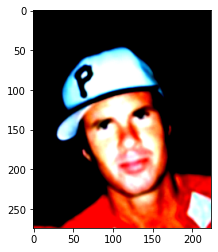

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


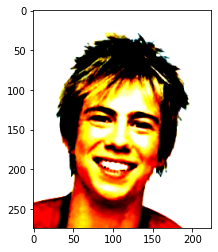

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


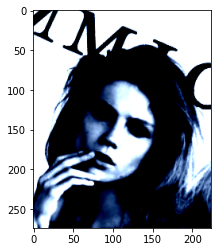

1
1
0


In [ ]:
#Read the training dataframe
training_df = pd.read_pickle(PATH +'train.pkl')
training_directory = PATH + 'train/'

#Read the validation dataframe
valid_df = pd.read_pickle(PATH + 'valid.pkl')
validation_directory = PATH + 'valid/'

#Use gender_loader class to call images
training_dataloader = Gender_loader(training_df, training_directory, transform=train_trns)
validation_dataloader = Gender_loader(valid_df, validation_directory, transform=valid_trns)

#Plot three images to check transformations
plt.imshow(make_grid(training_dataloader[1]['image'].permute(1, 2, 0)))
plt.show()
plt.imshow(make_grid(training_dataloader[7]['image'].permute(1, 2, 0)))
plt.show()
plt.imshow(make_grid(training_dataloader[9]['image'].permute(1, 2, 0)))
plt.show()
print(training_dataloader[1]['label'])
print(training_dataloader[7]['label'])
print(training_dataloader[9]['label'])

In [ ]:
#Specify batch size, epochs
BATCH_SIZE = 10
EPOCHS = 20

#Set-up training and validation dataloaders
train_dl = DataLoader(training_dataloader, shuffle=True, batch_size=BATCH_SIZE)
valid_dl = DataLoader(validation_dataloader, shuffle=False, batch_size=BATCH_SIZE)

#Specify optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1,
                       amsgrad=False)

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

NameError: ignored

In [ ]:
#Define model function
def fit_model(epochs, model, dataloader, phase='training', volatile=False):
    pprint("Epoch: {}".format(epochs))

    #If training phase, train model
    if phase == 'training':
        model.train()
    #If validation phase, evaluate accuracy and loss of validation image set with trained model
    if phase == 'validataion':
        model.eval()
        volatile = True

    running_loss = []
    running_acc = []
    b = 0
    for i, data in enumerate(dataloader):
      
        inputs, target = data['image'].cuda(), data['label'].cuda()

        inputs, target = Variable(inputs), Variable(target)

        #If training phase, train the model, evaluate and print the loss and accuracy
        if phase == 'training':
            optimizer.zero_grad()

        outputs = model(inputs.float())

        outputs = outputs.to(device=device, dtype=torch.float32)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, target)

        acc_ = []

        accuracy = (get_num_correct(outputs, target)/BATCH_SIZE)
        acc_.append(accuracy)

        print('In Epoch', epochs)
        print('')
        print('predictions', preds)
        print('targets    ', target)
        print('Batch Accuracy is ' + "{:.2%}".format(accuracy))
        print('')
        print('Batch Loss is     ', loss)
        print('')        

        running_loss.append(loss.item())
        running_acc.append(np.asarray(acc_).mean())

        b += 1

        #If training phase, send loss backwards so model can 'learn'
        if phase == 'training':
            loss.backward()

            optimizer.step()

    total_batch_loss = np.asarray(running_loss).mean()
    total_batch_acc = np.asarray(running_acc).mean()

    pprint("{} loss is {} ".format(phase, total_batch_loss))
    pprint("{} accuracy is {} ".format(phase, total_batch_acc))


    return total_batch_loss, total_batch_acc

In [ ]:
#Set-up empty lists to improve performance
trn_losses = [];
trn_acc = []
val_losses = [];
val_acc = []

In [ ]:
#Train model and display progress
for i in tqdm(range(1, EPOCHS +1)):
    trn_l, trn_a = fit_model(i, model, train_dl)
    val_l, val_a = fit_model(i, model, valid_dl, phase='validation')
    trn_losses.append(trn_l);
    trn_acc.append(trn_a)
    val_losses.append(val_l);
    val_acc.append(val_a)

In [ ]:
#Plot and save training and validation losses
%matplotlib inline
plt.plot(trn_losses, label = 'training')
plt.plot(val_losses, label = 'validation')
plt.legend()
plt.show()
plt.savefig('/content/drive/My Drive/A1_loss.png')

In [ ]:
#Plot and save training and validation accuracies
plt.plot(trn_acc, label = 'training')
plt.plot(val_acc, label = 'validation')
plt.legend()
plt.show()
plt.savefig('/content/drive/My Drive/A1_acc.png')

In [ ]:
#Save model path so it can be called to evaluate new images
save_path = os.path.join(PATH + 'A1.pth')
torch.save(model, save_path)

In [ ]:
#Specify transforms for image predict function
model.eval()
test_transforms = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                 ])

#Create predict image class that can be called from main.py
def predict(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    image_tensor = image_tensor.to(device=device)
    outputs = model(image_tensor)
    outputs = outputs.to(device=device, dtype=torch.float32)
    _, preds = torch.max(outputs.data, 1)
    # index = output.data.cpu().numpy().argmax()
    return preds